# In this file we will evaluate the DVHs for the first three patients

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
COLORS = {'green': '#00afa5', 'blue': '#005ae8', 'orange': '#f17900', 'red': '#ae0060', 'gray': '#c5d5db'}
dataset = pd.read_excel('ACTION_patients_overlap_only.xlsx')
dataset['P_NUMBER'] = dataset['P_NUMBER'].fillna(method='ffill')
overlap_array = np.array(dataset['TOTAL_OVERLAP (cc)']).reshape(len(dataset['P_NUMBER'].unique()), 6)
import re
prescription_doses = []
for entry in dataset['PRESCRIPTION_DOSE']:
    if type(entry) == str:
        match = re.search(r'(\d+(?:\.\d+)?)\s*x\s*(\d+(?:\.\d+)?)', entry)
        if match:
            result = float(match.group(1)) * float(match.group(2))
            prescription_doses.append(result)

fraction_dictionary = {
    '1a': 0,
    '1aA': 1,
    '1aB': 2,
    '1aC': 3,
    '1aD': 4,
    '1aE': 5,
}

## Full Analysis

In [70]:
import adaptive_fractionation_overlap as afx

phys_doses = []
accum_doses = []
total_penalties = []
for index, patient_overlaps in enumerate(overlap_array):
    physical_doses, accumulated_doses, total_penalty = afx.adaptfx_full(patient_overlaps, number_of_fractions=5, min_dose = 6, max_dose = 10, mean_dose = prescription_doses[index]/5, dose_steps = 0.25)
    phys_doses.append(physical_doses)
    accum_doses.append(accumulated_doses)
    total_penalties.append(total_penalty)

In [73]:
intercept = afx.INTERCEPT
slope = afx.SLOPE

In [74]:
standard_penalties  = []
for index, patient_overlaps in enumerate(overlap_array):
    d_mean = prescription_doses[index] / 5
    standard_penalty = -afx.penalty_calc_single(d_mean,6,patient_overlaps[1:], intercept = intercept, slope = slope).sum()
    standard_penalties.append(standard_penalty)
benefits = np.array(total_penalties) - np.array(standard_penalties)

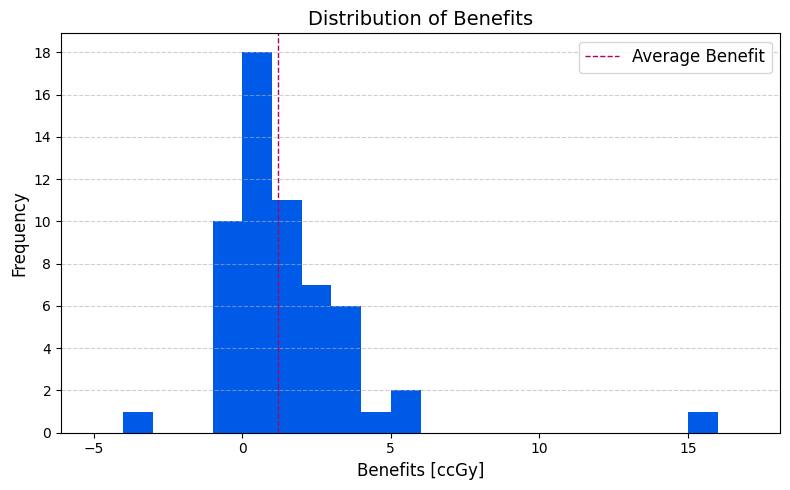

In [ ]:
plt.figure(figsize=(8, 5))
bins = np.arange(-5, 18, 1)
plt.hist(benefits, bins=bins, color=COLORS['blue'])
plt.xlabel('Benefits [ccGy]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Benefits', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.yticks(np.arange(0, 19, 2))
plt.axvline(x=np.mean(benefits), color=COLORS['red'], linestyle='--', linewidth=1, label='Average Benefit')
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

In [6]:
df = pd.DataFrame({
    'Patient number': dataset['P_NUMBER'].unique(),
    'Overlaps': overlap_array.tolist(),
    'Prescription': prescription_doses,
    'AF doses': phys_doses,
    'benefits': benefits,
    'penalties': total_penalties
})

In [7]:
import scipy.optimize as opt
# upper bound code
def calc_upper_bound_treatment(overlaps, prescription_dose, number_of_fractions, min_dose = 6, max_dose = 10):
    """
    Calculate the upper bound treatment for a given overlap and prescription dose.

    Parameters
    ----------
    overlaps : array
        The overlaps for the patient.
    prescription_dose : float
        The prescription dose for the patient.
    number_of_fractions : int
        The number of fractions in the treatment.

    Returns
    -------
    float
        The upper bound treatment value.
    """

    # Objective
    def penalty(doses):
        steepness = np.abs(intercept + slope * overlaps[1:])
        return np.sum((doses - min_dose) * overlaps[1:] + (doses - min_dose)**2*steepness/2)  # skip planning scan

    # Constraints: sum(doses) == prescription_dose, min_dose <= doses <= max_dose
    cons = ({
        'type': 'eq',
        'fun': lambda doses: np.sum(doses) - prescription_dose
    })
    bounds = [(min_dose, max_dose)] * number_of_fractions

    # Initial guess: equal split
    x0 = np.full(number_of_fractions, prescription_dose / number_of_fractions)

    res = opt.minimize(penalty, x0, bounds=bounds, constraints=cons)
    if res.success:
        # Calculate the minimized penalty value
        total_penalty = penalty(res.x)
        return res.x, total_penalty
    else:
        return None, None

# Calculate upper bounds for all patients and store in a DataFrame
upper_bound_doses = []
upper_bound_penalties = []
standard_penalties = np.array(standard_penalties)
for overlaps_looper, prescription in zip(overlap_array, prescription_doses):
    doses, penalty = calc_upper_bound_treatment(overlaps_looper, prescription, 5)
    upper_bound_doses.append(np.round(doses))
    upper_bound_penalties.append(penalty)
upper_bound_benefits = -np.array(upper_bound_penalties) - np.array(standard_penalties)
df_upper_bounds = pd.DataFrame({
    'Patient number': df['Patient number'],
    'Upper Bound Doses': upper_bound_doses,
    'Upper Bound Benefits': upper_bound_benefits
})

df_complete = pd.concat([df, df_upper_bounds[['Upper Bound Doses', 'Upper Bound Benefits']]], axis=1)


In [8]:
df_complete

,Patient number,Overlaps,Prescription,AF doses,benefits,penalties,Upper Bound Doses,Upper Bound Benefits
0,1.0,"[2.02, 2.41, 3.04, 1.96, 5.3, 3.27]",33.0,"[6.5, 6.25, 7.0, 6.0, 7.25]",0.890051,-10.567609,"[7.0, 6.0, 7.0, 6.0, 6.0]",2.215067
1,2.0,"[6.19, 10.97, 4.91, 7.65, 5.73, 5.87]",33.0,"[6.25, 7.25, 6.5, 6.75, 6.25]",2.213710,-22.974500,"[6.0, 7.0, 6.0, 7.0, 7.0]",3.681282
2,3.0,"[9.08, 19.79, 6.02, 9.45, 19.59, 12.62]",33.0,"[6.0, 8.0, 6.5, 6.0, 6.5]",15.681802,-32.694187,"[6.0, 8.0, 7.0, 6.0, 6.0]",16.311814
3,4.0,"[15.07, 19.81, 16.12, 22.630000000000003, 18.0...",33.0,"[6.25, 6.75, 6.25, 7.0, 6.75]",1.147655,-64.880875,"[6.0, 7.0, 6.0, 7.0, 7.0]",2.609190
4,5.0,"[17.150000000000002, 18.68, 18.35, 28.56000000...",33.0,"[6.5, 6.5, 6.25, 6.75, 7.0]",-0.799536,-79.626516,"[7.0, 7.0, 6.0, 7.0, 6.0]",4.171153
5,6.0,"[0.25, 0.53, 0.99, 2.66, 2.41, 0.27]",35.0,"[6.25, 6.0, 6.0, 7.25, 9.5]",2.689969,-6.399531,"[7.0, 6.0, 6.0, 6.0, 10.0]",5.912391
6,7.0,"[5.41, 8.2, 9.16, 8.18, 5.45, 7.28]",40.0,"[7.5, 7.5, 8.25, 9.0, 7.75]",3.415719,-122.875281,"[8.0, 7.0, 8.0, 9.0, 8.0]",4.842806
7,8.0,"[0.41, 2.37, 0.68, 2.67, 1.62, 1.27]",40.0,"[6.75, 9.75, 6.75, 8.25, 8.5]",5.988719,-22.424281,"[7.0, 10.0, 7.0, 8.0, 9.0]",6.446805
8,9.0,"[9.52, 12.18, 8.52, 9.39, 9.639999999999999, 8...",33.0,"[6.5, 7.0, 6.5, 6.5, 6.5]",0.253912,-34.556438,"[6.0, 7.0, 7.0, 7.0, 7.0]",1.124118
9,10.0,"[4.58, 5.78, 6.3, 3.83, 4.67, 2.69]",33.0,"[6.5, 6.5, 7.0, 6.5, 6.5]",0.310340,-16.374250,"[6.0, 6.0, 7.0, 6.0, 8.0]",3.039377


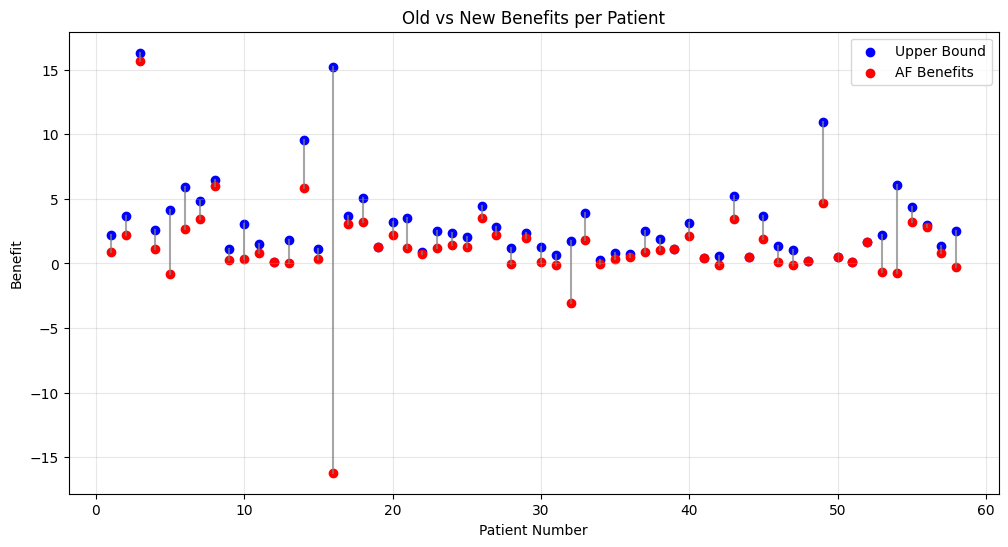

In [9]:
plt.figure(figsize=(12, 6))
x = df_complete['Patient number'].values
plt.scatter(x, df_complete['Upper Bound Benefits'], color='blue', label='Upper Bound')
plt.scatter(x, df_complete['benefits'], color='red', label='AF Benefits')

for i in range(len(x)):
    plt.plot([x[i], x[i]], [df_complete['Upper Bound Benefits'][i], df_complete['benefits'][i]], color='gray', linestyle='-', alpha=0.7)

plt.xlabel('Patient Number')
plt.ylabel('Benefit')
plt.title('Old vs New Benefits per Patient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Compare to old AF doses

In [10]:
import ast
old_results_df = pd.read_excel('../../adaptfx_results.xlsx')
# Convert the Overlaps column from string back to list
old_results_df['Overlaps'] = old_results_df['Overlaps'].apply(ast.literal_eval)
af_doses_list = [np.fromstring(item.strip('[]'), sep=' ') for item in old_results_df['AF doses']]
old_results_df['AF doses'] = af_doses_list

In [11]:
benefits_old_AF = []
total_penalties_old_AF = []
for index in range(len(overlap_array)):
    total_penalty = -afx.penalty_calc_single(af_doses_list[index],6,overlap_array[index][1:], intercept = intercept, slope = slope)
    benefits_old_AF.append(total_penalty.sum() - standard_penalties[index])
    total_penalties_old_AF.append(total_penalty)


In [15]:
standard_penalties

array([-1.145766e+01, -2.518821e+01, -4.837599e+01, -6.602853e+01,
       -7.882698e+01, -9.089500e+00, -1.262910e+02, -2.841300e+01,
       -3.481035e+01, -1.668459e+01, -2.703000e+00, -1.060000e-01,
       -4.723625e+01, -1.697325e+01, -1.216350e+01, -9.553500e+01,
       -3.710000e+00, -5.830000e+00, -1.285250e+00, -1.204425e+01,
       -2.164623e+01, -9.010000e-01, -2.712275e+01, -1.340900e+01,
       -2.080250e+00, -1.468100e+01, -2.130207e+01, -1.138596e+01,
       -1.796700e+01, -2.588370e+01, -1.199541e+01, -4.026000e+00,
       -1.191175e+01, -2.430630e+00, -7.327250e+00, -1.312110e+00,
       -2.795750e+00, -4.558000e+00, -1.126250e+00, -6.373250e+00,
       -6.890000e-01, -6.492500e+00, -7.605500e+00, -5.610000e-01,
       -5.742000e+00, -6.373250e+00, -1.456175e+01, -1.722500e-01,
       -8.448000e+01, -5.300000e-01, -1.457500e-01, -1.788750e+00,
       -1.637700e+01, -1.620300e+01, -8.141100e+01, -3.630000e+00,
       -1.599750e+00, -3.432000e+00])

In [12]:
total_penalties_old_AF

[array([ -0.   ,  -0.   , -11.613,  -0.   ,  -0.   ]),
 array([ -0.     , -29.09175,  -0.     ,  -0.     ,  -0.     ]),
 array([ -0.    , -35.6685,  -0.    ,  -0.    ,  -0.    ]),
 array([  -0.     ,   -0.     ,   -0.     , -107.18325,   -0.     ]),
 array([  -0.    ,   -0.    ,   -0.    ,   -0.    , -136.1565]),
 array([-0.     , -0.     , -0.     , -3.19325, -2.484  ]),
 array([ -0.   ,  -0.   , -75.256, -50.14 , -24.024]),
 array([ -0.   ,  -6.256,  -0.   ,  -5.346, -11.684]),
 array([ -0.   , -50.481,  -0.   ,  -0.   ,  -0.   ]),
 array([ -0.     ,  -0.     , -22.69275,  -0.     ,  -0.     ]),
 array([-0.     , -0.     , -0.27825, -0.     , -2.852  ]),
 array([-0., -0., -0., -0., -0.]),
 array([ -0.     ,  -0.     ,  -8.46675, -54.924  ,  -0.     ]),
 array([-0.   , -0.   , -4.876, -2.544, -0.   ]),
 array([ -0.   ,  -0.   ,  -0.   , -15.088,  -2.014]),
 array([ -0.   ,  -0.   , -31.464, -19.767, -84.364]),
 array([-0., -0., -0., -0., -0.]),
 array([-1.09975, -0.     , -0.     , -0

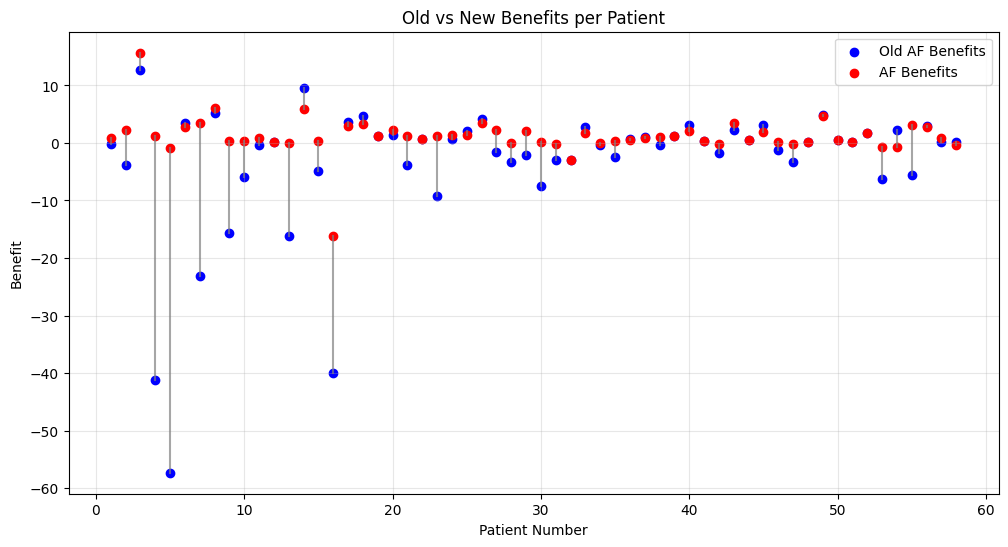

In [53]:
plt.figure(figsize=(12, 6))
x = df_complete['Patient number'].values
plt.scatter(x, benefits_old_AF, color='blue', label='Old AF Benefits')
plt.scatter(x, df_complete['benefits'], color='red', label='AF Benefits')

for i in range(len(x)):
    plt.plot([x[i], x[i]], [benefits_old_AF[i], df_complete['benefits'][i]], color='gray', linestyle='-', alpha=0.7)

plt.xlabel('Patient Number')
plt.ylabel('Benefit')
plt.title('Old vs New Benefits per Patient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
df_old_AF = pd.DataFrame({
    'Patient number': df['Patient number'],
    'Old AF Doses': af_doses_list,
    'Old AF Benefits': benefits_old_AF
})
df_complete = pd.concat([df_complete, df_old_AF[['Old AF Doses', 'Old AF Benefits']]], axis=1)


In [ ]:
df_complete

,Patient number,Overlaps,Prescription,AF doses,benefits,penalties,Upper Bound Doses,Upper Bound Benefits,Old AF Doses,Old AF Benefits
0,1.0,"[2.02, 2.41, 3.04, 1.96, 5.3, 3.27]",33.0,"[6.5, 6.25, 7.0, 6.0, 7.25]",0.890051,-10.567609,"[7.0, 6.0, 7.0, 6.0, 6.0]",2.215067,"[6.0, 6.0, 9.0, 6.0, 6.0]",-0.15534
1,2.0,"[6.19, 10.97, 4.91, 7.65, 5.73, 5.87]",33.0,"[6.25, 7.25, 6.5, 6.75, 6.25]",2.213710,-22.974500,"[6.0, 7.0, 6.0, 7.0, 7.0]",3.681282,"[6.0, 9.0, 6.0, 6.0, 6.0]",-3.90354
2,3.0,"[9.08, 19.79, 6.02, 9.45, 19.59, 12.62]",33.0,"[6.0, 8.0, 6.5, 6.0, 6.5]",15.681802,-32.694187,"[6.0, 8.0, 7.0, 6.0, 6.0]",16.311814,"[6.0, 9.0, 6.0, 6.0, 6.0]",12.70749
3,4.0,"[15.07, 19.81, 16.12, 22.630000000000003, 18.0...",33.0,"[6.25, 6.75, 6.25, 7.0, 6.75]",1.147655,-64.880875,"[6.0, 7.0, 6.0, 7.0, 7.0]",2.609190,"[6.0, 6.0, 6.0, 9.0, 6.0]",-41.15472
4,5.0,"[17.150000000000002, 18.68, 18.35, 28.56000000...",33.0,"[6.5, 6.5, 6.25, 6.75, 7.0]",-0.799536,-79.626516,"[7.0, 7.0, 6.0, 7.0, 6.0]",4.171153,"[6.0, 6.0, 6.0, 6.0, 9.0]",-57.32952
5,6.0,"[0.25, 0.53, 0.99, 2.66, 2.41, 0.27]",35.0,"[6.25, 6.0, 6.0, 7.25, 9.5]",2.689969,-6.399531,"[7.0, 6.0, 6.0, 6.0, 10.0]",5.912391,"[6.0, 6.0, 6.0, 7.0, 10.0]",3.41225
6,7.0,"[5.41, 8.2, 9.16, 8.18, 5.45, 7.28]",40.0,"[7.5, 7.5, 8.25, 9.0, 7.75]",3.415719,-122.875281,"[8.0, 7.0, 8.0, 9.0, 8.0]",4.842806,"[6.0, 6.0, 10.0, 10.0, 8.0]",-23.12900
7,8.0,"[0.41, 2.37, 0.68, 2.67, 1.62, 1.27]",40.0,"[6.75, 9.75, 6.75, 8.25, 8.5]",5.988719,-22.424281,"[7.0, 10.0, 7.0, 8.0, 9.0]",6.446805,"[6.0, 10.0, 6.0, 8.0, 10.0]",5.12700
8,9.0,"[9.52, 12.18, 8.52, 9.39, 9.639999999999999, 8...",33.0,"[6.5, 7.0, 6.5, 6.5, 6.5]",0.253912,-34.556438,"[6.0, 7.0, 7.0, 7.0, 7.0]",1.124118,"[6.0, 9.0, 6.0, 6.0, 6.0]",-15.67065
9,10.0,"[4.58, 5.78, 6.3, 3.83, 4.67, 2.69]",33.0,"[6.5, 6.5, 7.0, 6.5, 6.5]",0.310340,-16.374250,"[6.0, 6.0, 7.0, 6.0, 8.0]",3.039377,"[6.0, 6.0, 9.0, 6.0, 6.0]",-6.00816


In [60]:
(df_complete['benefits'] < df_complete['Old AF Benefits']).sum()

15

(array([1., 1., 0., 0., 0., 1., 1., 2., 5., 4.]),
 array([-3.6855625 , -3.32411719, -2.96267188, -2.60122656, -2.23978125,
        -1.87833594, -1.51689063, -1.15544531, -0.794     , -0.43255469,
        -0.07110938]),
 <BarContainer object of 10 artists>)

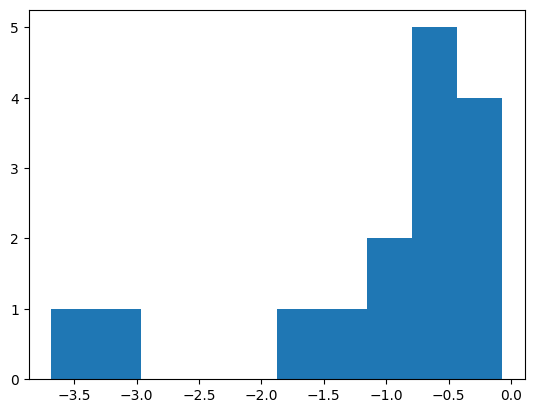

In [68]:
plt.hist((df_complete['benefits'] - df_complete['Old AF Benefits'])[(df_complete['benefits'] < df_complete['Old AF Benefits'])])

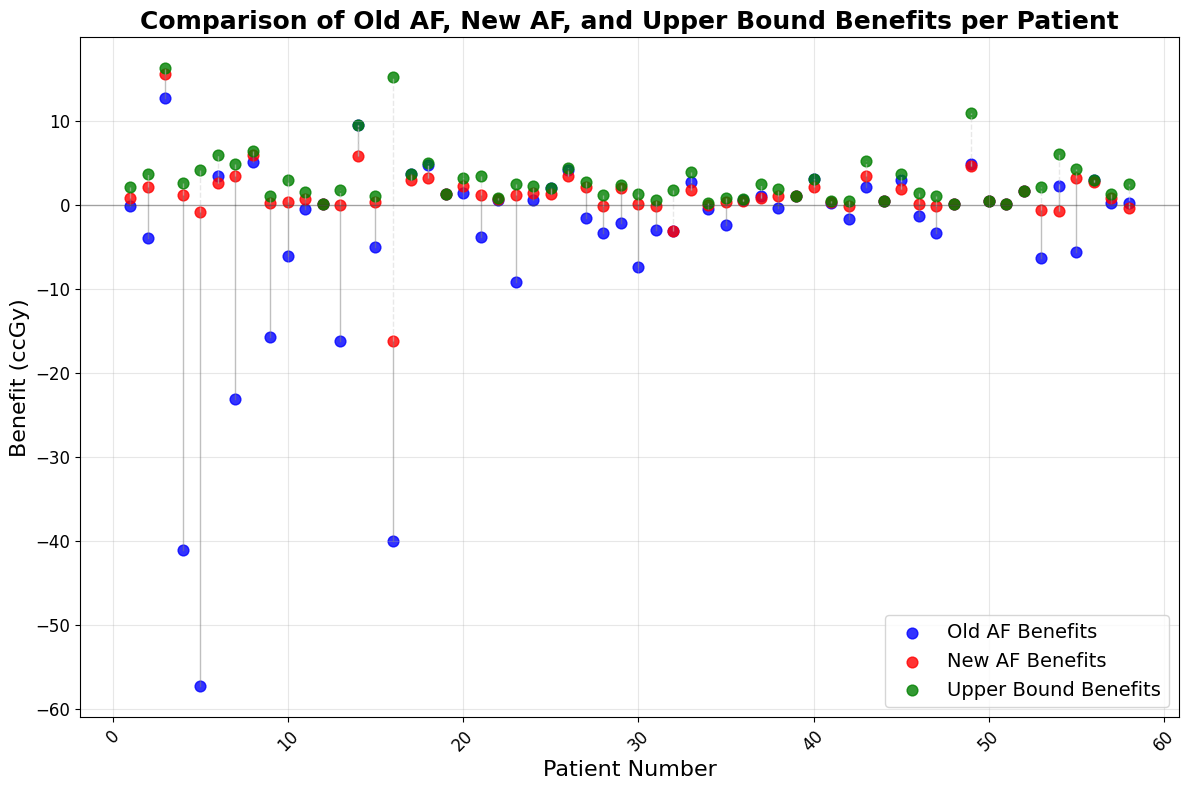

In [58]:
# Plot comparing Old AF, New AF, and Upper Bound benefits
plt.figure(figsize=(12, 8))
x = df_complete['Patient number'].values

# Plot all three treatment types
plt.scatter(x, df_complete['Old AF Benefits'], color='blue', label='Old AF Benefits', s=60, alpha=0.8)
plt.scatter(x, df_complete['benefits'], color='red', label='New AF Benefits', s=60, alpha=0.8)
plt.scatter(x, df_complete['Upper Bound Benefits'], color='green', label='Upper Bound Benefits', s=60, alpha=0.8)

# Add connecting lines between treatments for each patient
for i in range(len(x)):
    # Line from Old AF to New AF
    plt.plot([x[i], x[i]], [df_complete['Old AF Benefits'][i], df_complete['benefits'][i]], 
             color='gray', linestyle='-', alpha=0.5, linewidth=1)
    # Line from New AF to Upper Bound
    plt.plot([x[i], x[i]], [df_complete['benefits'][i], df_complete['Upper Bound Benefits'][i]], 
             color='lightgray', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel('Patient Number', fontsize=16)
plt.ylabel('Benefit (ccGy)', fontsize=16)
plt.title('Comparison of Old AF, New AF, and Upper Bound Benefits per Patient', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.grid(True, alpha=0.3)

# Add horizontal line at zero for reference
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Let's compare some more

In [42]:
old_doses_array = np.array(list(df_complete['Old AF Doses']))

In [43]:
# Convert both arrays to numpy arrays with proper shape
new_doses_array = np.array([np.array(doses) for doses in df_complete['AF doses']])
print(f"New doses shape: {new_doses_array.shape}")
print(f"Old doses shape: {old_doses_array.shape}")

# Calculate the difference
dose_differences = new_doses_array - old_doses_array
print(f"Difference shape: {dose_differences.shape}")
print(f"First few differences:\n{dose_differences[:5]}")


New doses shape: (58, 5)
Old doses shape: (58, 5)
Difference shape: (58, 5)
First few differences:
[[ 0.5   0.25 -2.    0.    1.25]
 [ 0.25 -1.75  0.5   0.75  0.25]
 [ 0.   -1.    0.5   0.    0.5 ]
 [ 0.25  0.75  0.25 -2.    0.75]
 [ 0.5   0.5   0.25  0.75 -2.  ]]


In [47]:
dose_differences_upper = new_doses_array -np.array(list(df_complete['Upper Bound Doses'])) 

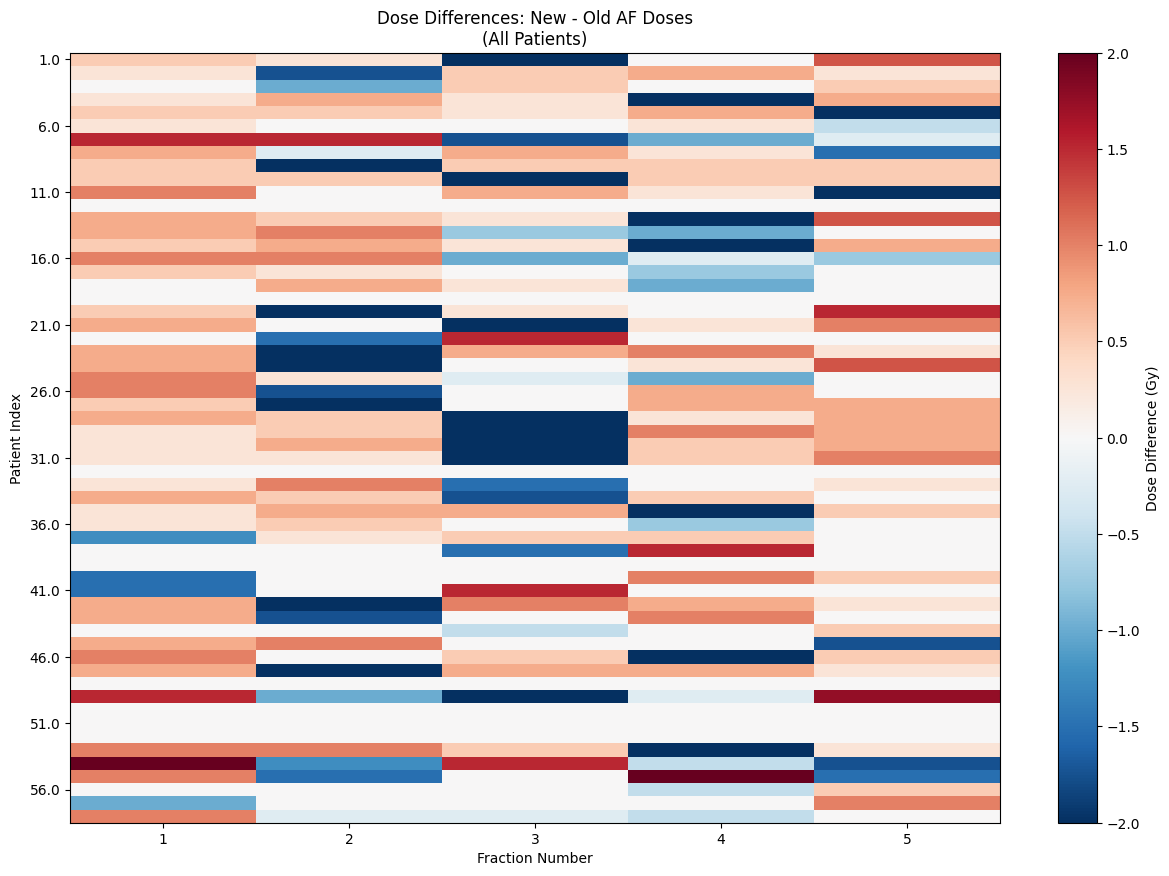

Patients with no changes: 8
Patients with any changes: 50


In [45]:
# Create a nice visualization of dose differences
plt.figure(figsize=(15, 10))

# Get patient numbers for labeling
patient_numbers = df_complete['Patient number'].values

# Create a heatmap-style plot
plt.subplot(1,1,1)
im = plt.imshow(dose_differences, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
plt.colorbar(im, label='Dose Difference (Gy)')
plt.title('Dose Differences: New - Old AF Doses\n(All Patients)', fontsize=12)
plt.xlabel('Fraction Number')
plt.ylabel('Patient Index')
plt.xticks(range(5), range(1, 6))
plt.yticks(range(0, len(patient_numbers), 5), patient_numbers[::5])
plt.show()

print(f"Patients with no changes: {np.sum(np.all(dose_differences == 0, axis=1))}")
print(f"Patients with any changes: {np.sum(np.any(dose_differences != 0, axis=1))}")

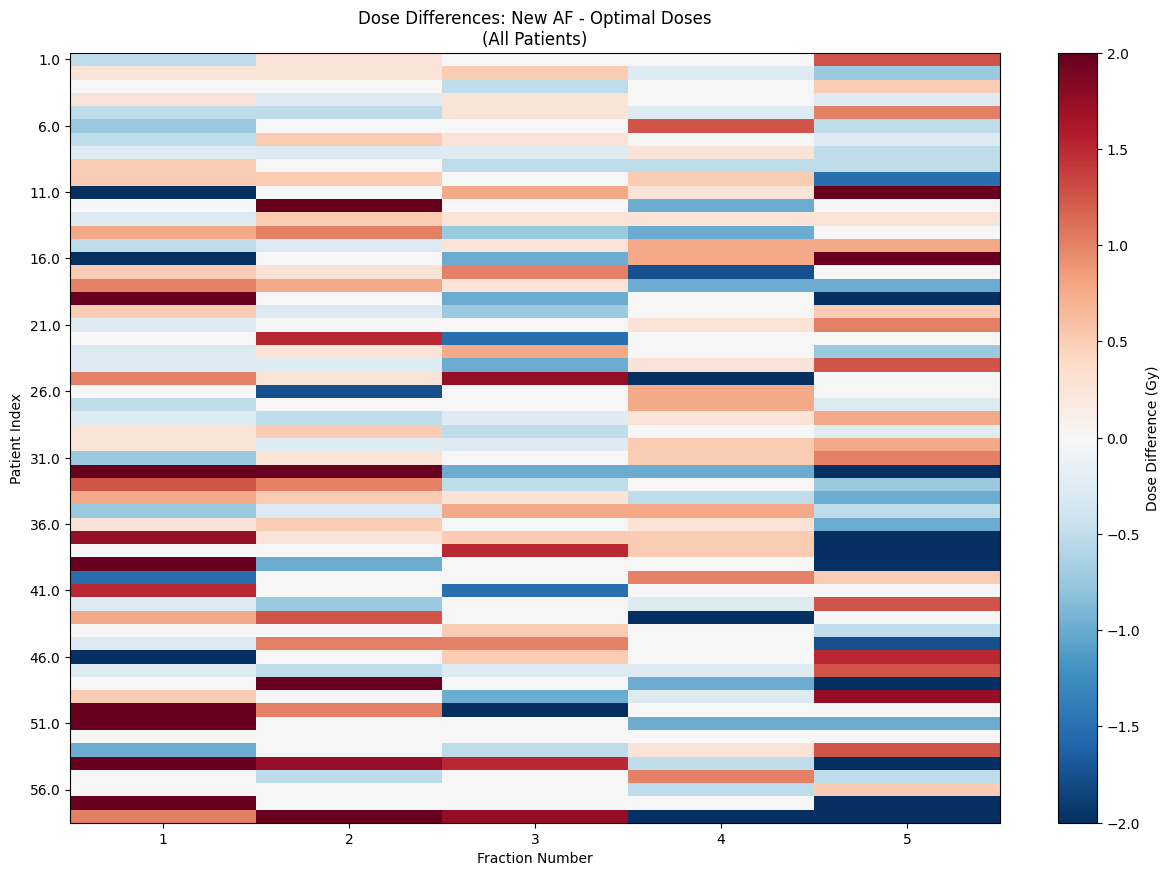

Patients with no changes: 1
Patients with any changes: 57


In [48]:
# Create a nice visualization of dose differences
plt.figure(figsize=(15, 10))

# Get patient numbers for labeling
patient_numbers = df_complete['Patient number'].values

# Create a heatmap-style plot
plt.subplot(1,1,1)
im = plt.imshow(dose_differences_upper, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
plt.colorbar(im, label='Dose Difference (Gy)')
plt.title('Dose Differences: New AF - Optimal Doses\n(All Patients)', fontsize=12)
plt.xlabel('Fraction Number')
plt.ylabel('Patient Index')
plt.xticks(range(5), range(1, 6))
plt.yticks(range(0, len(patient_numbers), 5), patient_numbers[::5])
plt.show()

print(f"Patients with no changes: {np.sum(np.all(dose_differences_upper == 0, axis=1))}")
print(f"Patients with any changes: {np.sum(np.any(dose_differences_upper != 0, axis=1))}")

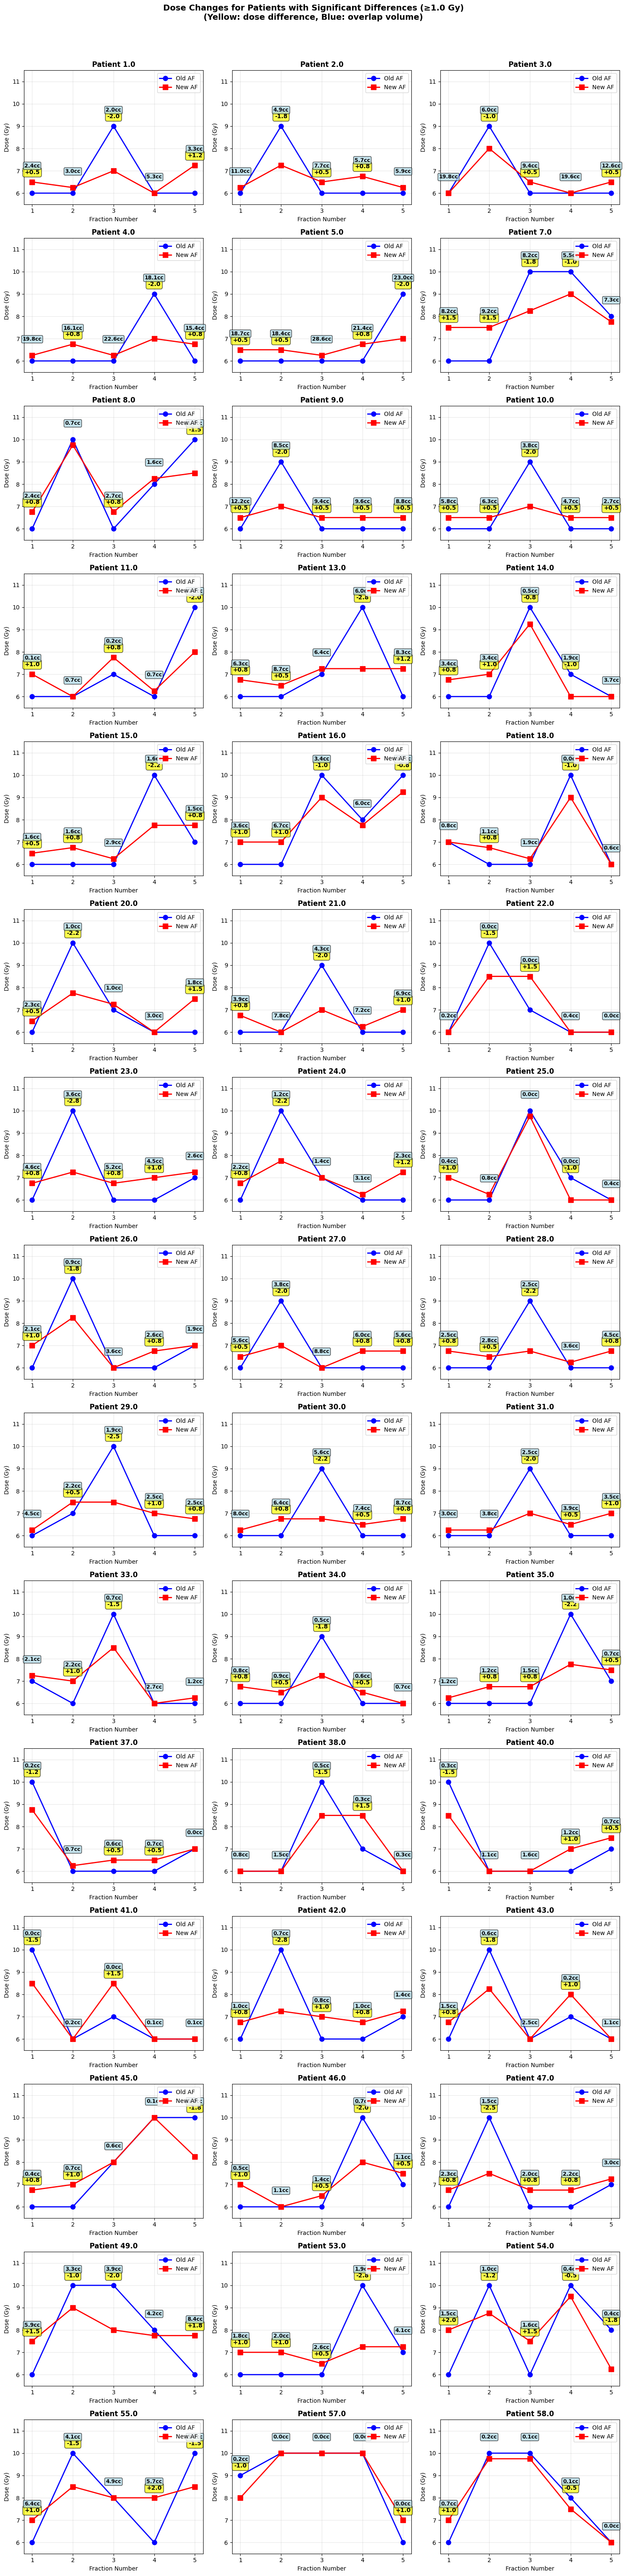


Showing 45 patients with dose changes ≥ 1.0 Gy:
  Patient 1.0
  Patient 2.0
  Patient 3.0
  Patient 4.0
  Patient 5.0
  Patient 7.0
  Patient 8.0
  Patient 9.0
  Patient 10.0
  Patient 11.0
  Patient 13.0
  Patient 14.0
  Patient 15.0
  Patient 16.0
  Patient 18.0
  Patient 20.0
  Patient 21.0
  Patient 22.0
  Patient 23.0
  Patient 24.0
  Patient 25.0
  Patient 26.0
  Patient 27.0
  Patient 28.0
  Patient 29.0
  Patient 30.0
  Patient 31.0
  Patient 33.0
  Patient 34.0
  Patient 35.0
  Patient 37.0
  Patient 38.0
  Patient 40.0
  Patient 41.0
  Patient 42.0
  Patient 43.0
  Patient 45.0
  Patient 46.0
  Patient 47.0
  Patient 49.0
  Patient 53.0
  Patient 54.0
  Patient 55.0
  Patient 57.0
  Patient 58.0


In [46]:
# Detailed view: Show dose differences for patients with significant changes
significant_change_threshold = 1.0  # Gy
patients_with_changes = []

for i, patient_num in enumerate(patient_numbers):
    if np.any(np.abs(dose_differences[i]) >= significant_change_threshold):
        patients_with_changes.append((i, patient_num))

if patients_with_changes:
    # Calculate number of subplots needed
    n_patients = len(patients_with_changes)
    n_cols = min(3, n_patients)
    n_rows = (n_patients + n_cols - 1) // n_cols
    
    plt.figure(figsize=(5*n_cols, 4*n_rows))
    
    for plot_idx, (patient_idx, patient_num) in enumerate(patients_with_changes):
        plt.subplot(n_rows, n_cols, plot_idx + 1)
        
        fractions = range(1, 6)
        old_doses = old_doses_array[patient_idx]
        new_doses = new_doses_array[patient_idx]
        differences = dose_differences[patient_idx]
        
        # Get overlap values for this patient (skip planning scan - index 0)
        patient_overlaps = df_complete['Overlaps'].iloc[patient_idx][1:]  # Skip first element (planning scan)
        
        # Plot old vs new doses
        plt.plot(fractions, old_doses, 'o-', label='Old AF', linewidth=2, markersize=8, color='blue')
        plt.plot(fractions, new_doses, 's-', label='New AF', linewidth=2, markersize=8, color='red')
        
        # Add difference annotations and overlap values
        for frac, diff, overlap in zip(fractions, differences, patient_overlaps):
            y_max = max(old_doses[frac-1], new_doses[frac-1])
            
            # Add dose difference annotation
            if abs(diff) >= 0.5:  # Only annotate substantial differences
                plt.annotate(f'{diff:+.1f}', 
                           xy=(frac, y_max + 0.3),
                           ha='center', va='bottom', fontsize=10, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
            
            # Add overlap annotation
            plt.annotate(f'{overlap:.1f}cc', 
                       xy=(frac, y_max + 0.6),
                       ha='center', va='bottom', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))
        
        plt.title(f'Patient {patient_num}', fontsize=12, fontweight='bold')
        plt.xlabel('Fraction Number')
        plt.ylabel('Dose (Gy)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(fractions)
        plt.ylim(5.5, 11.5)  # Increased upper limit to accommodate annotations
    
    plt.tight_layout()
    plt.suptitle(f'Dose Changes for Patients with Significant Differences (≥{significant_change_threshold} Gy)\n(Yellow: dose difference, Blue: overlap volume)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    print(f"\nShowing {len(patients_with_changes)} patients with dose changes ≥ {significant_change_threshold} Gy:")
    for _, patient_num in patients_with_changes:
        print(f"  Patient {patient_num}")
else:
    print(f"No patients found with dose changes ≥ {significant_change_threshold} Gy")

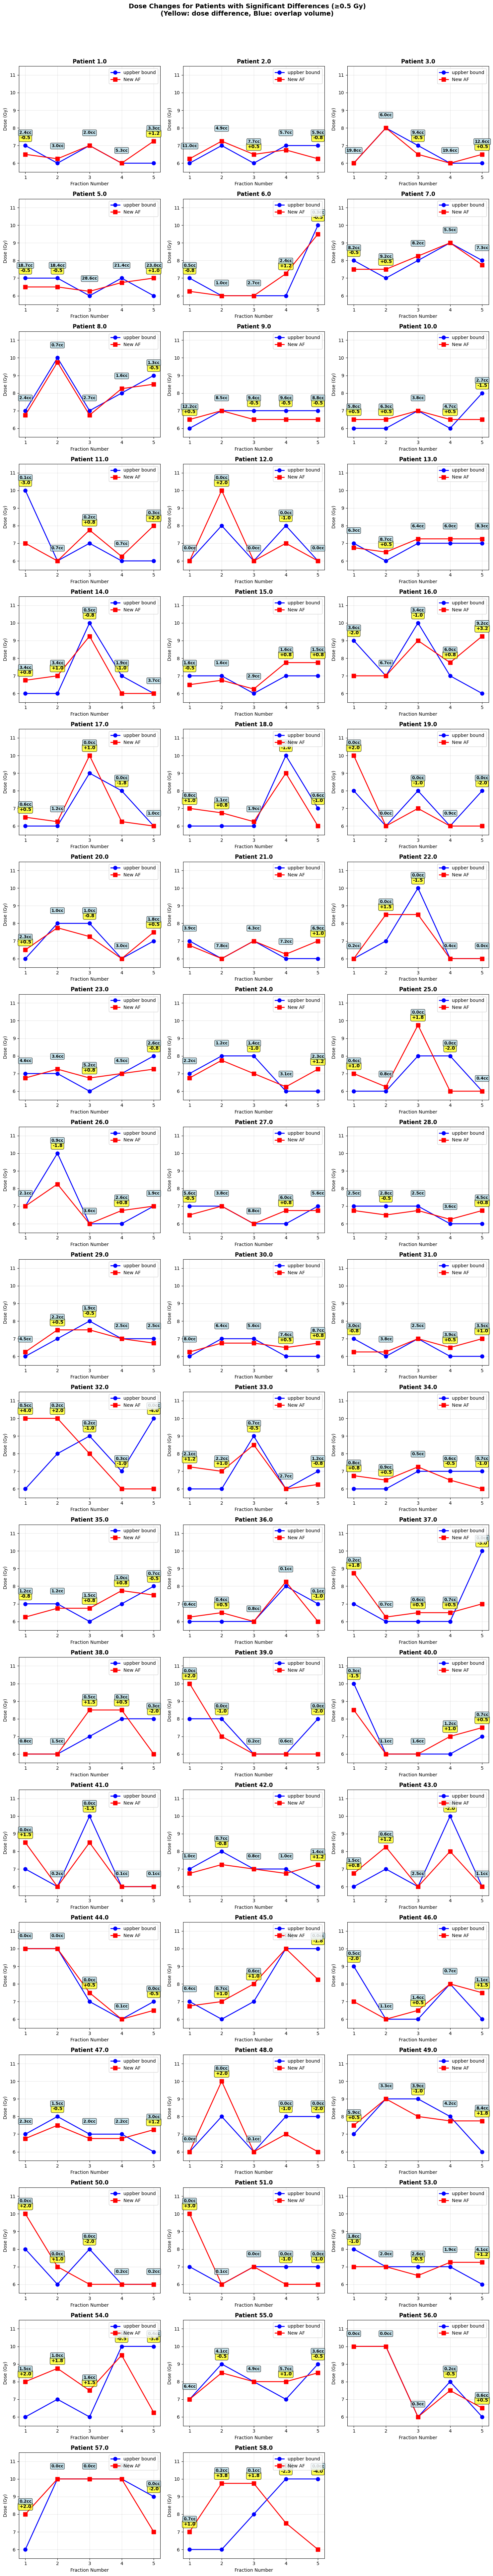


Showing 56 patients with dose changes ≥ 0.5 Gy:
  Patient 1.0
  Patient 2.0
  Patient 3.0
  Patient 5.0
  Patient 6.0
  Patient 7.0
  Patient 8.0
  Patient 9.0
  Patient 10.0
  Patient 11.0
  Patient 12.0
  Patient 13.0
  Patient 14.0
  Patient 15.0
  Patient 16.0
  Patient 17.0
  Patient 18.0
  Patient 19.0
  Patient 20.0
  Patient 21.0
  Patient 22.0
  Patient 23.0
  Patient 24.0
  Patient 25.0
  Patient 26.0
  Patient 27.0
  Patient 28.0
  Patient 29.0
  Patient 30.0
  Patient 31.0
  Patient 32.0
  Patient 33.0
  Patient 34.0
  Patient 35.0
  Patient 36.0
  Patient 37.0
  Patient 38.0
  Patient 39.0
  Patient 40.0
  Patient 41.0
  Patient 42.0
  Patient 43.0
  Patient 44.0
  Patient 45.0
  Patient 46.0
  Patient 47.0
  Patient 48.0
  Patient 49.0
  Patient 50.0
  Patient 51.0
  Patient 53.0
  Patient 54.0
  Patient 55.0
  Patient 56.0
  Patient 57.0
  Patient 58.0


In [51]:
# Detailed view: Show dose differences for patients with significant changes
significant_change_threshold = 0.5  # Gy
patients_with_changes = []

for i, patient_num in enumerate(patient_numbers):
    if np.any(np.abs(dose_differences_upper[i]) >= significant_change_threshold):
        patients_with_changes.append((i, patient_num))

if patients_with_changes:
    # Calculate number of subplots needed
    n_patients = len(patients_with_changes)
    n_cols = min(3, n_patients)
    n_rows = (n_patients + n_cols - 1) // n_cols
    
    plt.figure(figsize=(5*n_cols, 4*n_rows))
    
    for plot_idx, (patient_idx, patient_num) in enumerate(patients_with_changes):
        plt.subplot(n_rows, n_cols, plot_idx + 1)
        
        fractions = range(1, 6)
        ub_doses = upper_bound_doses[patient_idx]
        new_doses = new_doses_array[patient_idx]
        differences = dose_differences_upper[patient_idx]
        
        # Get overlap values for this patient (skip planning scan - index 0)
        patient_overlaps = df_complete['Overlaps'].iloc[patient_idx][1:]  # Skip first element (planning scan)
        
        # Plot old vs new doses
        plt.plot(fractions, ub_doses, 'o-', label='uppber bound', linewidth=2, markersize=8, color='blue')
        plt.plot(fractions, new_doses, 's-', label='New AF', linewidth=2, markersize=8, color='red')
        
        # Add difference annotations and overlap values
        for frac, diff, overlap in zip(fractions, differences, patient_overlaps):
            y_max = max(ub_doses[frac-1], new_doses[frac-1])
            
            # Add dose difference annotation
            if abs(diff) >= 0.5:  # Only annotate substantial differences
                plt.annotate(f'{diff:+.1f}', 
                           xy=(frac, y_max + 0.3),
                           ha='center', va='bottom', fontsize=10, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
            
            # Add overlap annotation
            plt.annotate(f'{overlap:.1f}cc', 
                       xy=(frac, y_max + 0.6),
                       ha='center', va='bottom', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))
        
        plt.title(f'Patient {patient_num}', fontsize=12, fontweight='bold')
        plt.xlabel('Fraction Number')
        plt.ylabel('Dose (Gy)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(fractions)
        plt.ylim(5.5, 11.5)  # Increased upper limit to accommodate annotations
    
    plt.tight_layout()
    plt.suptitle(f'Dose Changes for Patients with Significant Differences (≥{significant_change_threshold} Gy)\n(Yellow: dose difference, Blue: overlap volume)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    print(f"\nShowing {len(patients_with_changes)} patients with dose changes ≥ {significant_change_threshold} Gy:")
    for _, patient_num in patients_with_changes:
        print(f"  Patient {patient_num}")
else:
    print(f"No patients found with dose changes ≥ {significant_change_threshold} Gy")